In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import random
import os
import datetime
from statsmodels.graphics.tsaplots import plot_pacf
from pandas.plotting import lag_plot
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

In [37]:
#we want to select some batch data from our stocks folder

while True:
    vals = []
    for i in range(4):
        number = random.randint(0,len(os.listdir("../data/raw/Stock_data/Stocks")))
        vals.append(number)

    counter = 0
    test_stocks = []
    names = []
    for file in os.listdir("../data/raw/Stock_data/Stocks"):
        if counter in vals:
            df = pd.read_csv("../data/raw/Stock_data/Stocks/" + file)
            test_stocks.append(df)
            names.append(file)
        counter += 1
    
    len_counter = 0
    for df in test_stocks:
        if len(df) > 1000:
            len_counter += 1
    
    if len_counter == 4:
        break
        

names



['bf-a.us.txt', 'bpl.us.txt', 'corr.us.txt', 'fnhc.us.txt']

In [52]:
test_stocks[0]

,Date,Open,High,Low,Close,Volume,OpenInt
0,2010-08-23,19.434,19.681,19.428,19.477,14499,0
1,2010-08-24,19.389,19.672,19.389,19.609,7014,0
2,2010-08-25,19.583,19.645,19.418,19.586,6310,0
3,2010-08-26,19.632,19.635,19.467,19.505,6539,0
4,2010-08-27,19.477,19.675,19.448,19.655,8194,0
...,...,...,...,...,...,...,...
1812,2017-11-06,55.710,55.795,55.220,55.340,13964,0
1813,2017-11-07,55.200,55.900,55.150,55.810,16850,0
1814,2017-11-08,55.820,56.550,55.820,56.490,22143,0
1815,2017-11-09,56.630,56.950,56.450,56.900,11589,0


Note that all the time series end at the year 2017, so we will use the year 2017 as our test data.

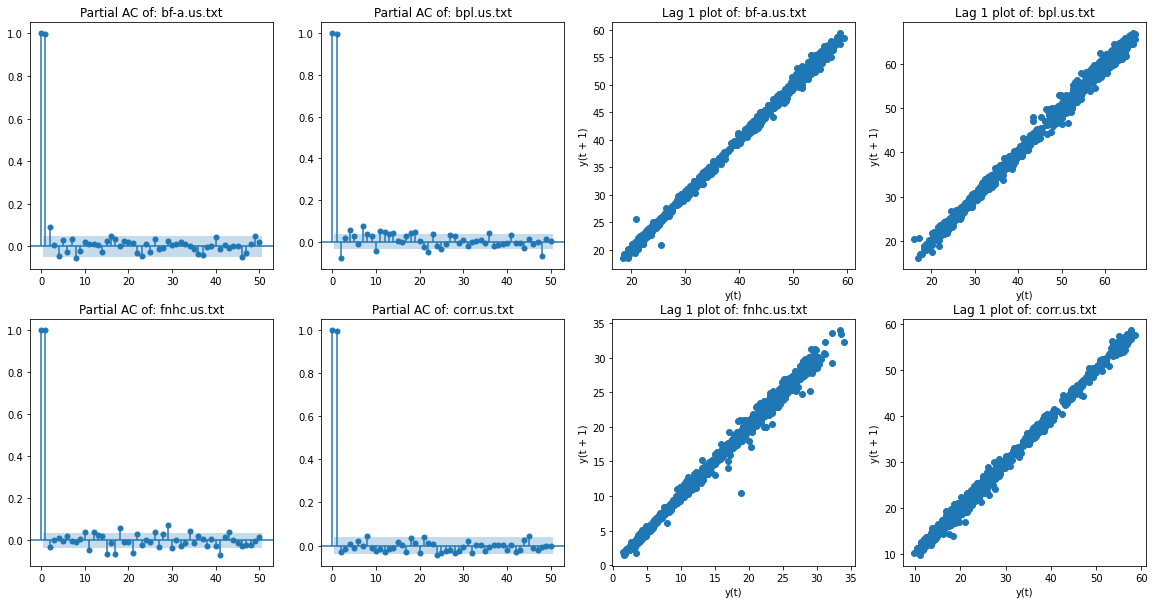

In [51]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize= (20,10))
counter = 0
for df in test_stocks:
    df["Date"] = pd.to_datetime(df["Date"])
    test = df[df["Date"] > datetime.datetime(2017, 1, 1)]
    train = df[df["Date"] <= datetime.datetime(2017, 1, 1)]

    if counter < 2:
        #pacf
        plot_pacf(train["Close"], lags=50,ax=axes[0,counter])
        axes[0,counter].title.set_text("Partial AC of: " + names[counter])

        #lag plot
        lag_plot(train["Close"], lag=1, ax=axes[0,counter +2 ])
        axes[0,counter+2].title.set_text("Lag 1 plot of: " + names[counter])
    else:
        if counter == 3:
            plot_pacf(train["Close"], lags=50,ax=axes[1,0])
            axes[1,0].title.set_text("Partial AC of: " + names[counter])

            lag_plot(train["Close"], lag=1, ax=axes[1,2])
            axes[1,2].title.set_text("Lag 1 plot of: " + names[counter])
        
        else:
            plot_pacf(train["Close"], lags=50,ax=axes[1,1])
            axes[1,1].title.set_text("Partial AC of: " + names[counter])

            lag_plot(train["Close"], lag=1, ax=axes[1,3])
            axes[1,3].title.set_text("Lag 1 plot of: " + names[counter])
    counter += 1

    

 

After a few batch tests it is clear that most stocks are only stronly correlated with lag 1. The correlation of previouse days is overall inconclusive

In [58]:
import time
name_counter = 0
for df in test_stocks:
    df["Date"] = pd.to_datetime(df["Date"])
    test = df[df["Date"] > datetime.datetime(2017, 1, 1)]
    train = df[df["Date"] <= datetime.datetime(2017, 1, 1)]
    df = df.drop(columns=["Open","Volume", "High", "Low", "OpenInt"])

    arima_results = []
    ar_results = []

    start = time.time()

    for i in range(len(test)):
        model = ARIMA(train["Close"], order = (1,1,1))
        model_fit = model.fit()
        arima_results.append(model_fit.forecast().iloc[0])
        train = train.append({"Close": test.iloc[i]["Close"], "Date":test.iloc[i]["Date"]}, ignore_index=True)
    
    end = time.time()

    print("For stock: ", + names[name_counter])
    

    print("ARIMA TIme:", end-start)
    
    start = time.time()

    for i in range(len(test)):
        model = AutoReg(train["Close"], lags = 1, old_names=False)
        model_fit = model.fit()
        ar_results.append(model_fit.predict(start=len(train), end=len(train)))
        train = train.append({"Close": test.iloc[i]["Close"], "Date":test.iloc[i]["Date"]}, ignore_index=True)

    end = time.time()
    print("AR TIme:", end-start)

    print("ERROR COMPARISON:")
    print("ARIMA MSE:", mean_absolute_percentage_error(arima_results, test["Close"].values.tolist()))
    print("AR ABPE:", mean_absolute_percentage_error(ar_results, test["Close"].values.tolist()))
    name_counter += 1
    

ARIMA TIme: 20.640663385391235
AR TIme: 1.67799973487854
ERROR COMPARISON:
ARIMA MSE: 0.008157142139022563
AR MSE: 0.00903344678782811
ARIMA TIme: 48.307684898376465
AR TIme: 1.9928689002990723
ERROR COMPARISON:
ARIMA MSE: 0.008932705856262104
AR MSE: 0.009913058700813307
ARIMA TIme: 55.67564606666565
AR TIme: 1.6789700984954834
ERROR COMPARISON:
ARIMA MSE: 0.010905451964467806
AR MSE: 0.01127597374423606
ARIMA TIme: 27.367111682891846
AR TIme: 1.6204190254211426
ERROR COMPARISON:
ARIMA MSE: 0.01746755193989299
AR MSE: 0.018727199746829553
